# TUTORIAL FOR THE P3D EMULATOR (FORESTFLOW)

In [1]:
import sys
import os
import matplotlib.pyplot as plt

In [4]:
from ForestFlow.archive import GadgetArchive3D
from ForestFlow.plots_v0 import plot_test_p3d
from ForestFlow.P3D_cINN import P3DEmulator

In [5]:
def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder

path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

/nfs/pic.es/user/l/lcabayol/DESI/ForestFlow/


## LOAD P3D ARCHIVE

In [6]:
%%time
folder_lya_data = path_program +  "/data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program[:-1], 
    folder_data=folder_lya_data, 
    force_recompute_plin=True,
    average='both'
)
print(len(Archive3D.training_data))


No file with Plin in /nfs/pic.es/user/l/lcabayol/DESI/ForestFlow/data/
1650
CPU times: user 1min 50s, sys: 3.8 s, total: 1min 54s
Wall time: 2min 41s


## TRAIN EMULATOR

In [8]:
p3d_emu = P3DEmulator(
    Archive3D.training_data,
    Archive3D.emu_params,
    nepochs=300,
    lr=0.001,#0.005
    batch_size=20,
    step_size=200,
    gamma=0.1,
    weight_decay=0,
    adamw=True,
    nLayers_inn=12,#15
    Archive=Archive3D,
    use_chains=False,
    chain_samp=100_000,
    folder_chains='/data/desi/scratch/jchavesm/p3d_fits_new/'
)

Emulator optimized in 2.5340213775634766 seconds


## TEST EMULATOR

fit {'bias': -0.2265946739714242, 'beta': 1.2248241556400337, 'q1': 0.5508070368332233, 'kvav': 0.7735041489709146, 'av': 0.5316646888234277, 'bv': 1.841648720663841, 'kp': 13.45975658765607, 'q2': 0.1882466279205535}
emu {'bias': 0.2609166204929352, 'beta': 0.962457001209259, 'q1': 0.5612202286720276, 'kvav': 0.829315185546875, 'av': 0.4970334470272064, 'bv': 1.7695062160491943, 'kp': 12.712664604187012, 'q2': 0.288737490773201}


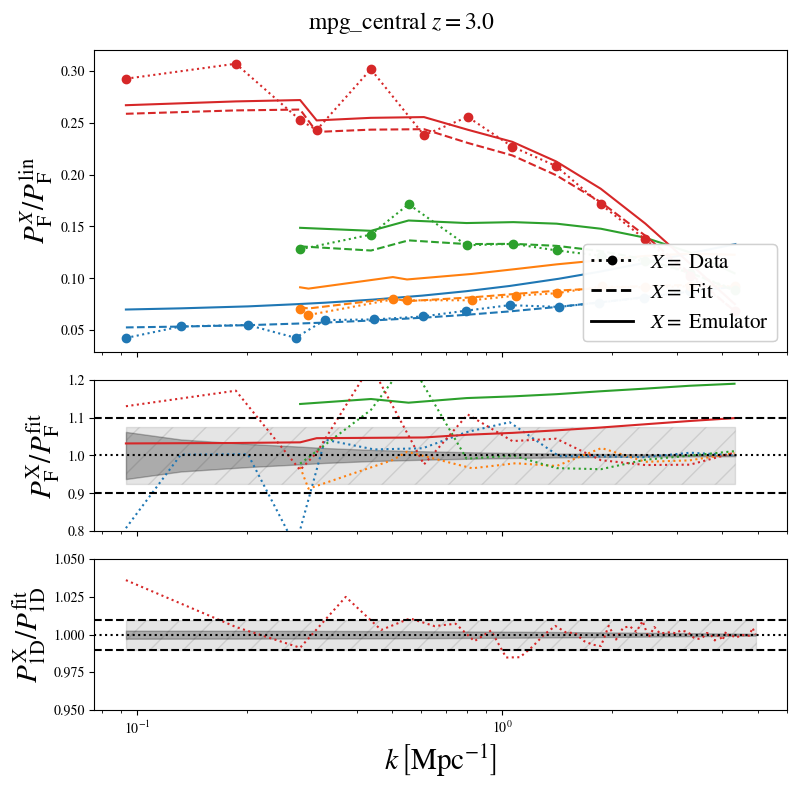

In [9]:
sim_label = "mpg_central"
ind_book = 6
plot_test_p3d(ind_book, Archive3D, p3d_emu, sim_label)

## LOAD TRAINED EMULATOR

To load a trained model, one needs to specify the path to the model in the argument 'model_path'.

The folder '/data/emulator_models/' contains the models trained with all the Latinhypercube simulations: 'mpg_hypercube.pt' 

In [10]:
p3d_emu = P3DEmulator(
    Archive3D.training_data,
    Archive3D.emu_params,
    nepochs=300,
    lr=0.001,#0.005
    batch_size=20,
    step_size=200,
    gamma=0.1,
    weight_decay=0,
    adamw=True,
    nLayers_inn=12,#15
    Archive=Archive3D,
    use_chains=False,
    chain_samp=100_000,
    folder_chains='/data/desi/scratch/jchavesm/p3d_fits_new/',
    model_path='../data/emulator_models/mpg_hypercube.pt'
)

fit {'bias': -0.2265946739714242, 'beta': 1.2248241556400337, 'q1': 0.5508070368332233, 'kvav': 0.7735041489709146, 'av': 0.5316646888234277, 'bv': 1.841648720663841, 'kp': 13.45975658765607, 'q2': 0.1882466279205535}
emu {'bias': 0.22963041067123413, 'beta': 1.2103052139282227, 'q1': 0.4978519082069397, 'kvav': 0.7533842623233795, 'av': 0.5163390338420868, 'bv': 1.8042138814926147, 'kp': 13.426518440246582, 'q2': 0.23059292137622833}


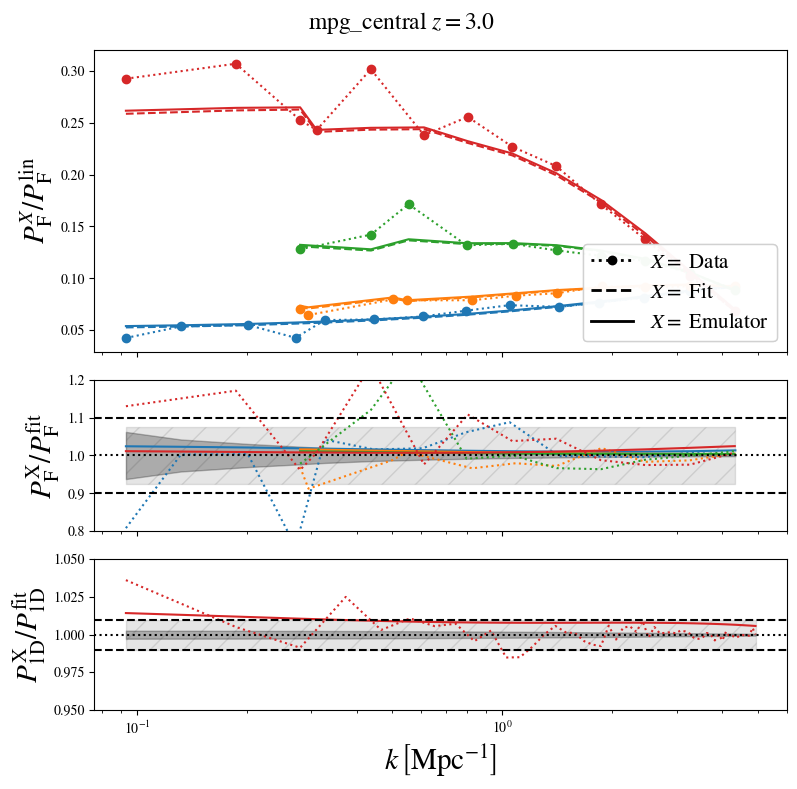

In [11]:
sim_label = "mpg_central"
ind_book = 6
plot_test_p3d(ind_book, Archive3D, p3d_emu, sim_label)

## PREDICT P1D AND P3D

In [12]:
sim_label = "mpg_central"
z_test=3

In [13]:
test_sim = central = Archive3D.get_testing_data(
        "mpg_central", 
        force_recompute_plin=True
        )
dict_sim = [d for d in test_sim if d['z']==z_test and d['val_scaling'] ==1]

In [14]:
p3d_pred, p3d_cov = p3d_emu.predict_P3D_Mpc(
                        sim_label='mpg_central',
                        z=z_test,
                        test_sim=dict_sim,    
                        return_cov=True)

In [15]:
p1d_pred, p1d_cov = p3d_emu.predict_P1D_Mpc(
                        sim_label='mpg_central',
                        z=z_test,
                        test_sim=dict_sim,    
                        return_cov=True)